# Features Extractions and XGBoost Classification:


## 1. Load and Explore a CSV file


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import neurokit2 as nk
import biobss

#sns.set_style('whitegrid')

/Users/mingli/Documents/anaconda3/lib/python3.11/site-packages/plotly_resampler-0.8.2-py3.11.egg/plotly_resampler/aggregation/aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.


In [2]:
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from collections import defaultdict


In [348]:
participant_codes = ['3B8D','03FH','3RFH','4JF9','93DK','93JD','AP3H','F408',
                     'H39D','JD3K','K2Q2','KF93','KS03','LAS2','LDM5','LK27','ME93']

# the index-5 participant '93JD' do not contain all features
# the index-16 participant 'ME93' do not contain all features, but it contains "ecg:dry", "eda:dry" and six "acc"
# we will discard these two participants in the following list
# there is some problem with "KS03" if including "ppg" signal

selected_participants = ['3B8D','03FH','3RFH','4JF9','93DK','AP3H','F408',
                     'H39D','JD3K','K2Q2','KF93','KS03', 'LAS2','LDM5','LK27', 'ME93']

In [340]:
features_ISST = ['ecg:dry', 'ecg:gel', 'eda:gel', 'emg:Left Bicep',
                 'ppg:Left index finger', 'acc_chest:x', 'acc_chest:y', 'acc_chest:z']
features_E4 = ['eda:dry', 'temp:temp', 'ppg:Left Wrist', 'acc_e4:x', 'acc_e4:y', 'acc_e4:z']
# there are in total 14 features


features_combined = features_ISST + features_E4


tot_columns = ['ecg:dry', 'ecg:gel', 'eda:dry', 'eda:gel', 'emg:Left Bicep', 'temp:temp',
 'ppg:Left index finger', 'ppg:Left Wrist', 'acc_e4:z', 'acc_e4:x', 'acc_e4:y',
 'acc_chest:x', 'acc_chest:y', 'acc_chest:z', 'activities']



In [5]:
#encoding the eight different activities with numbers 1-8. Note that the slightly different descriptions

activity_encoder = {'baseline,':1,'lift,':2,'lift-1,':2, 'lift-2,':2,
                    'greetings,':3, 
                    'gesticulate,':4, 'jumps,':5, 
                    'walk_before,':6,'walk_before_downstairs,':6,'walk_before_elevatorup,':6,'walk_before_elevatordown,':6,
                    'run,':7, 'sprint,run,':7,
                    'walk_after,':8, 'run,walk_after':8, 'run,walk_after,':8}

In [352]:
# the data is taken with frequence 500 Hz, which means 500 data points in a sequence represents 1 second in time. 
# One can adjust the segmentation window to cut the time series, for example, 10 seconds, 20 seconds....
fs = 500
n_timepoints = 500*10


motions_acc= defaultdict(list)
motions_labels = []
acc_columns = [  'ecg:dry','eda:dry', 'temp:temp','ppg:Left Wrist', 
               'acc_e4:z', 'acc_e4:x', 'acc_e4:y','acc_chest:x', 'acc_chest:y', 'acc_chest:z','activities']

In [353]:
for code in selected_participants: 
    signals = pd.read_csv(f'csv/{code}.csv', index_col=0, parse_dates=True, low_memory=False)
    
    signals_copy  = signals[acc_columns].copy()
    signals_copy.dropna(inplace=True)
    #all_columns = signals_copy.columns.values
    #print("the features are: ", all_columns)
    #all_channels = all_columns[:-1]
    
    signals_copy['activities'] = signals_copy['activities'].replace(activity_encoder)
    signals_copy['activities'] = pd.to_numeric(signals_copy['activities'])
    activity_num=signals_copy['activities'].unique()
    
    for k in range(1,9):
        if k in signals_copy['activities'].unique():
            change_row = signals_copy.loc[signals_copy['activities']==k].index[0]
            signals_copy.loc[change_row, 'activities']=0
    
    #events variable contains the onset and duration of different activities
    events = nk.events_find(event_channel=signals_copy['activities'], 
                        threshold = 0,
                        threshold_keep='above', 
                        event_conditions=activity_num)
    
    for i in range(len(events['onset'])):
        itr = events['duration'][i]//n_timepoints
        j=1
        while j<= itr:
            #Extracting features from "acc:chest" and "acc:e4" (wrist)
            accCHx = signals_copy.iloc[events['onset'][i] + n_timepoints*(j-1): events['onset'][i]+n_timepoints*j,:]['acc_chest:x'].values
            accCHy = signals_copy.iloc[events['onset'][i] + n_timepoints*(j-1): events['onset'][i]+n_timepoints*j,:]['acc_chest:y'].values
            accCHz = signals_copy.iloc[events['onset'][i] + n_timepoints*(j-1): events['onset'][i]+n_timepoints*j,:]['acc_chest:z'].values
            accWx = signals_copy.iloc[events['onset'][i] + n_timepoints*(j-1): events['onset'][i]+n_timepoints*j,:]['acc_e4:x'].values
            accWy = signals_copy.iloc[events['onset'][i] + n_timepoints*(j-1): events['onset'][i]+n_timepoints*j,:]['acc_e4:y'].values
            accWz = signals_copy.iloc[events['onset'][i] + n_timepoints*(j-1): events['onset'][i]+n_timepoints*j,:]['acc_e4:z'].values
            acc_CH_features = biobss.imutools.get_acc_features(signals=[accCHx, accCHy,accCHz], signal_names=['accCHx','accCHy', 'accCHz'], sampling_rate=fs)
            acc_W_features = biobss.imutools.get_acc_features(signals=[accWx, accWy,accWz], signal_names=['accWx','accWy', 'accWz'], sampling_rate=fs)
            
            #Extracting features from "eda:dry".
            eda_dry = signals_copy.iloc[events['onset'][i] + n_timepoints*(j-1): events['onset'][i]+n_timepoints*j,:]['eda:dry'].values            
            filtered_eda_dry = biobss.edatools.eda_filter.filter_eda(eda_dry,fs)
            eda_dry_features = biobss.edatools.eda_features.from_signal(filtered_eda_dry, sampling_rate=fs)
            
            #Extracting features from "ecg:dry".
            ecg_dry = signals_copy.iloc[events['onset'][i] + n_timepoints*(j-1): events['onset'][i]+n_timepoints*j,:]['ecg:dry'].values            
            filtered_ecg_dry = biobss.preprocess.filter_signal(ecg_dry, sampling_rate=fs, 
                                                      signal_type='ECG', method='elgendi')
            ecg_dry_locs_peaks=biobss.ecgtools.ecg_detectpeaks(sig = filtered_ecg_dry,sampling_rate = fs,method='elgendi')
            ecg_dry_features = biobss.ecgtools.ecg_features.from_Rpeaks(filtered_ecg_dry, ecg_dry_locs_peaks, fs,
                                                            prefix='ecgDry', average=True)
            
            #Extracting features from "ppg"
            ppg_wrist = signals_copy.iloc[events['onset'][i] + n_timepoints*(j-1): events['onset'][i]+n_timepoints*j,:]['ppg:Left Wrist'].values
            filtered_ppg_wrist = ppg_wrist
            
            info_wrist=biobss.ppgtools.ppg_detectpeaks(sig=filtered_ppg_wrist, sampling_rate=fs, method='peakdet', delta=0.01, correct_peaks=True)
            locs_peaks_wrist=info_wrist['Peak_locs']
            peaks_wrist=filtered_ppg_wrist[locs_peaks_wrist]
            locs_onsets_wrist=info_wrist['Trough_locs']
            onsets_wrist=filtered_ppg_wrist[locs_onsets_wrist]
            
            features_all_wrist = biobss.ppgtools.get_ppg_features(sig=filtered_ppg_wrist, sampling_rate=fs,
                                                      input_types=['cycle','segment'], 
                                                      feature_domain={'cycle':['Time'],'segment':['time','freq','stat']},
                                                      peaks_locs=locs_peaks_wrist, peaks_amp=peaks_wrist,
                                                      troughs_locs=locs_onsets_wrist, troughs_amp=onsets_wrist,
                                                      prefix = 'ppgW')
            #Extract features from "temp"
            temp_ts = signals_copy.iloc[events['onset'][i] + n_timepoints*(j-1): events['onset'][i]+n_timepoints*j,:]['temp:temp'].values
            temp_dict = { "temp_median": np.median(temp_ts), "temp_max": np.max(temp_ts), "temp_min": np.min(temp_ts)}
            
            #concatenating all the features into a dictionary
            for acc_features in (acc_CH_features, acc_W_features, eda_dry_features,
                                 ecg_dry_features,  features_all_wrist, temp_dict):
                for ky, val in acc_features.items():
                    motions_acc[ky].append(val)
            #record the corresponding labels for activities   
            motions_labels.append(events['condition'][i])
            j = j+1
    print(f"Finished extracting data from participant {code}.")

motions_dict = dict(motions_acc)
motions_df = pd.DataFrame(motions_dict)
motions_df['activities'] = motions_labels

print("finish extracting all data. ")

Finished extracting data from participant 3B8D.
Finished extracting data from participant 03FH.
Finished extracting data from participant 3RFH.
Finished extracting data from participant 4JF9.
Finished extracting data from participant 93DK.
Finished extracting data from participant AP3H.
Finished extracting data from participant F408.
Finished extracting data from participant H39D.
Finished extracting data from participant JD3K.
Finished extracting data from participant K2Q2.
Finished extracting data from participant KF93.
Finished extracting data from participant KS03.
Finished extracting data from participant LAS2.
Finished extracting data from participant LDM5.
Finished extracting data from participant LK27.
Finished extracting data from participant ME93.
finish extracting all data. 


In [354]:
print("input shape: ", motions_df.shape)


input shape:  (3137, 305)


In [365]:
motions_df.replace([np.inf, -np.inf], np.nan, inplace=True)
motions_df.dropna(inplace=True)

In [355]:
all_motions = ['baseline','lift',
                    'greetings', 
                    'gesticulate', 'jumps', 
                    'walk_before',
                    'run',
                    'walk_after']

In [356]:
unique_values, counts = np.unique(motions_df['activities'], return_counts=True)

count_motions = pd.DataFrame({  'activities': all_motions,"counts": counts, "codes":unique_values})
count_motions
#print("values: ", unique_values)
#print("counts: ", counts)

,activities,counts,codes
0,baseline,56,1
1,lift,95,2
2,greetings,58,3
3,gesticulate,144,4
4,jumps,12,5
5,walk_before,258,6
6,run,2287,7
7,walk_after,227,8


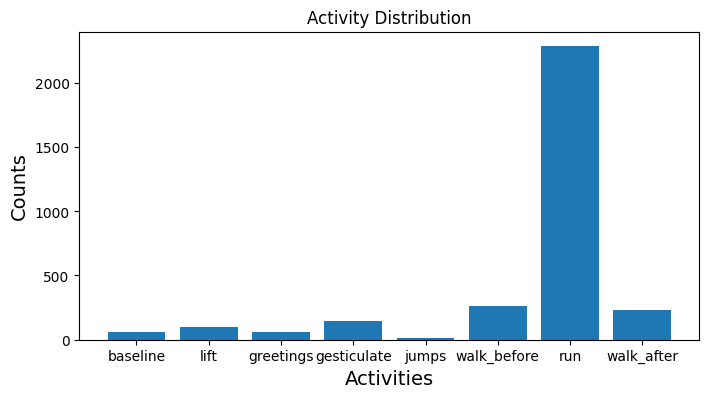

In [357]:
plt.figure(figsize = (8, 4))
plt.bar(count_motions['activities'], height = count_motions['counts'])
plt.xlabel("Activities", fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.title("Activity Distribution")
plt.show()

In [418]:
X=motions_df.iloc[:,:-1]
y=motions_df.iloc[:,-1:]

In [419]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, stratify = y, shuffle=True,
                                                    random_state=127)

print("X_train shape ", X_train.shape)
print("X_test shape ", X_test.shape)
print("y_train shape ", y_train.shape)
print("y_test shape ", y_test.shape)

X_train shape  (2445, 304)
X_test shape  (612, 304)
y_train shape  (2445, 1)
y_test shape  (612, 1)


In [420]:
#X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, 
#                                                    test_size = 0.2, stratify = y_train, shuffle=True,
#                                                    random_state=127)

#print("X_train shape ", X_train2.shape)
#print("X_test shape ", X_val.shape)
#print("y_train shape ", y_train2.shape)
#print("y_test shape ", y_val.shape)

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# 2. XGBoostClassifier

We use the XGBoostClassifier() to train on the training set and make prediction on the test set.

In [238]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder


In [421]:
le = LabelEncoder()
y_train = le.fit_transform(y_train.values.ravel())
#y_val = le.fit_transform(y_val.values.ravel())

In [422]:
max_depths = [ 2,3 ]
n_trees = [600,650]
lr = [ 0.4, 0.45]
colsample = [0.3, 0.4]

ti = time.time()


grid_cv = GridSearchCV(xgb.XGBClassifier(tree_method = 'hist'), 
                          param_grid = {'max_depth':max_depths, # place the grid values for max_depth and
                                        'n_estimators':n_trees,
                                        'learning_rate' : lr,
                                       'colsample_bytree': colsample,}, # and n_estimators here
                          scoring = 'neg_log_loss', # put the metric we are trying to optimize here as a string, "accuracy"
                          cv = 5,
                          n_jobs=-1) 

## you fit it just like a model
#grid_cv.fit(X_train2, y_train2, eval_set=[(X_train2, y_train2), (X_val, y_val)])
grid_cv.fit(X_train, y_train)

tf= time.time()
print("the total time of gridsearchcv is: ", tf-ti)

/Users/mingli/Documents/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/mingli/Documents/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/mingli/Documents/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/mingli/Documents/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/mingli/Documents/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred 

the total time of gridsearchcv is:  73.56660199165344


In [221]:
#xgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

In [423]:
print("cv best params: ", grid_cv.best_params_)
print("the best score (log_loss): ",grid_cv.best_score_)

cv best params:  {'colsample_bytree': 0.4, 'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 600}
the best score (log_loss):  -0.09580024930407575


In [424]:
xgb_clf_best = grid_cv.best_estimator_

In [425]:
y_pred = xgb_clf_best.predict(X_test)
y_pred = le.inverse_transform(y_pred)


In [411]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized

array([[0.81818182, 0.18181818, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.84210526, 0.        , 0.10526316, 0.        ,
        0.05263158, 0.        , 0.        ],
       [0.        , 0.08333333, 0.83333333, 0.08333333, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.96551724, 0.        ,
        0.03448276, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.5       ,
        0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.96078431, 0.03921569, 0.        ],
       [0.00225734, 0.        , 0.        , 0.        , 0.        ,
        0.00225734, 0.99322799, 0.00225734],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.08888889, 0.91111111]])

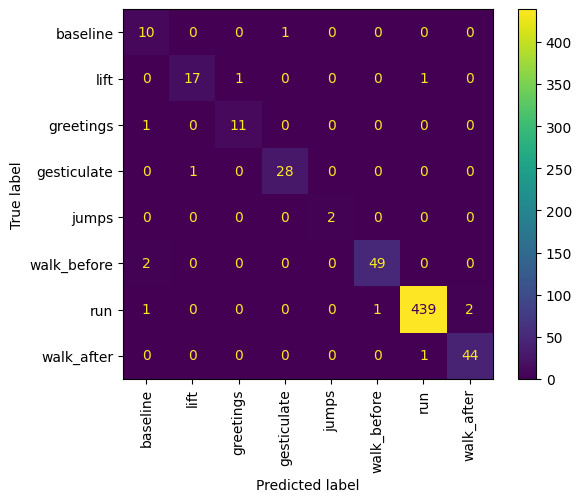

In [427]:
cmp_unnormalized = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels = all_motions, xticks_rotation='vertical')


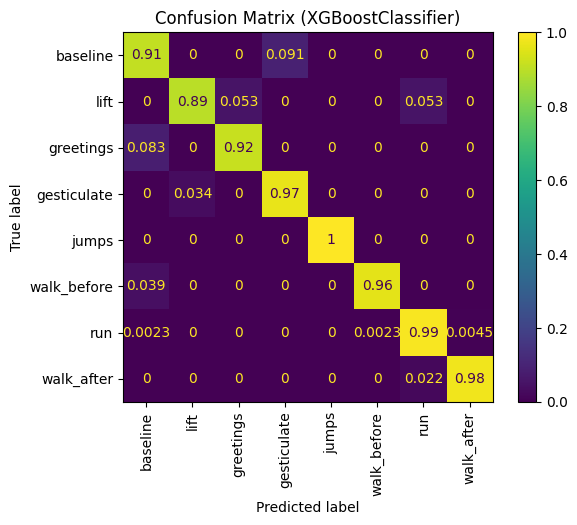

In [515]:
#plt.figure(figsize = (10,6))
cmp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels = all_motions,normalize='true', xticks_rotation='vertical')
plt.title("Confusion Matrix (XGBoostClassifier)")
plt.show()
#fig, ax = plt.subplots(figsize=(10,8))
#cmp.plot(ax=ax)

In [428]:
accuracy_score(y_test, y_pred)

0.9803921568627451

In [430]:
importance_xgb= xgb_clf_best.get_booster().get_score(importance_type='gain')
#importance_xgb

In [435]:
keys = list(importance_xgb.keys())
values = list(importance_xgb.values())

importance_feature_df = pd.DataFrame(data=values, index=keys, columns=["importance_score"]).sort_values(by = "importance_score", ascending=False)
top20_features = importance_feature_df.nlargest(20, columns="importance_score")

In [436]:
top20_features

,importance_score
accCHz_fft_entropy,149.900757
accCHx_range,116.924522
scr_acr_length,38.989189
accWx_medad,36.219257
accCHz_fft_energy,33.132187
accWx_std,26.097174
accWx_fft_max,25.400131
accCHx_iqr,21.371111
accWx_fft_energy,18.306524
accCHz_range,14.591431


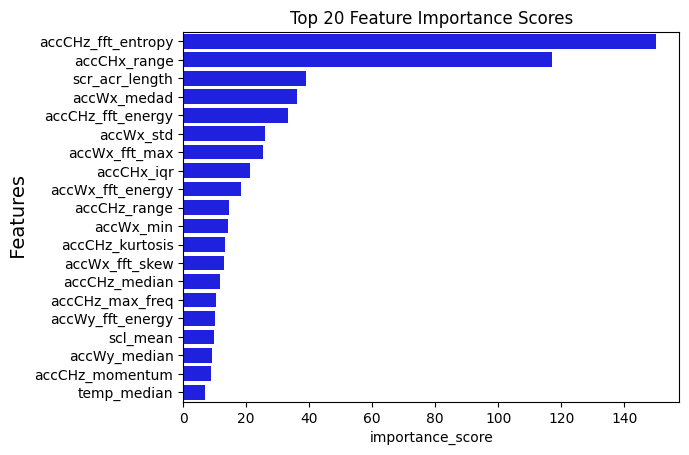

In [437]:
sns.barplot(x='importance_score', y=top20_features.index, data=top20_features,
            label="Total", color="b")
plt.title("Top 20 Feature Importance Scores")
plt.ylabel(" Features ", fontsize=14)
#plt.savefig("Top20_features_mine.png")
plt.show()

## The meanings of the top 20 features:

### ACC Features

#### Statistical features:

* mean: mean of the signal amplitude

* std: standard deviation of the signal amplitude

* mad: mean absolute deviation of the signal amplitude

* max: maximum value of the signal amplitude

* range: difference of maximum and minimum values of the signal amplitude

* medad: median absolute deviation of the signal amplitude

* iqr: interquartile range of the signal amplitude

* npeaks: number of peaks

* skew: skewness of the signal

* kurtosis: kurtosis of the signal
* pcount: number of positibe values
* energy: signal energy (the mean of sum of squares of the values in a window)
* median: median value of the signal amplitude
* ncount: number of negative values

#### Frequency domain features:

* fft_mean: mean of fft peaks

* fft_std: standard deviation of fft peaks

* fft_mad: mean absolute deviation of fft peaks

* fft_energy: energy of fft peaks

* fft_entropy: entropy of fft peaks
* fft_skew: skewness of fft peaks

### ECG Features

* 'RR2': Subsequent RR interval
* 'RR1': Current RR interval
* 'RR0': Previous RR interval
* 'RR_2_1': Ratio of RR2 to RR1

### EDA Features

* scl: Tonic EDA signal
* scr: Phasic EDA signal

# 3. RandomForestClassifier

In [438]:
from sklearn.ensemble import RandomForestClassifier


In [503]:
max_depths = [ 30, 40]
n_trees = [ 1800, 2000, 2500]
max_features = ['sqrt', 'log2']
#min_samples_split= [10, 20]

ti = time.time()


grid_cv_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=143, criterion='log_loss'), # first put the model object here
                          param_grid = {'max_depth':max_depths, # place the grid values for max_depth and
                                        'n_estimators':n_trees,
                                         'max_features': max_features,},
                                        #'min_samples_split': min_samples_split}, # and n_estimators here
                          scoring = 'neg_log_loss', # put the metric we are trying to optimize here as a string, "accuracy"
                          cv = 5,
                          n_jobs=-1) 

## you fit it just like a model
grid_cv_rf.fit(X_train, y_train)

tf= time.time()
print("the total time of gridsearchcv is: ", tf-ti)

the total time of gridsearchcv is:  252.2957308292389


In [504]:
print("the best parameters are: ", grid_cv_rf.best_params_)
print(" corresponding log loss score is: ",grid_cv_rf.best_score_ )

the best parameters are:  {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 2000}
 corresponding log loss score is:  -0.14826216829456285


In [505]:
rf_clf_best = grid_cv_rf.best_estimator_

y_pred_RF=rf_clf_best.predict(X_test)
y_pred_proba_RF = rf_clf_best.predict_proba(X_test)

In [506]:
y_pred_RF = le.inverse_transform(y_pred_RF)


In [507]:
print("the accuracy score on test set is: ", accuracy_score(y_test, y_pred_RF))
print("the log_loss score on test set is: ", log_loss(y_test, y_pred_proba_RF))

the accuracy score on test set is:  0.9689542483660131
the log_loss score on test set is:  0.130016046348568


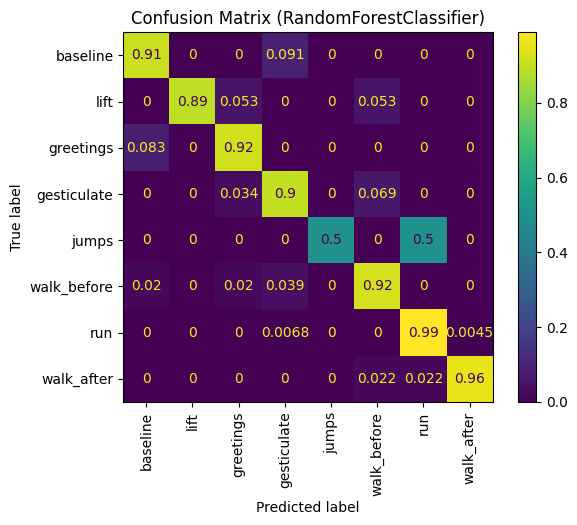

In [516]:
cmp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred_RF, display_labels = all_motions,normalize='true', xticks_rotation='vertical')
plt.title("Confusion Matrix (RandomForestClassifier)")
plt.show()

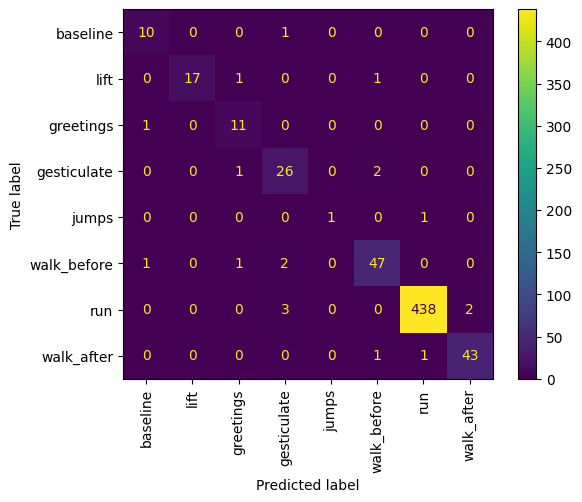

In [510]:
cmp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred_RF, display_labels = all_motions, xticks_rotation='vertical')

In [514]:
importance_df = pd.DataFrame({'importance_score':grid_cv_rf.best_estimator_.feature_importances_}).sort_values('importance_score',
                                                ascending=False)
feature_index = importance_df.loc[importance_df['importance_score']>=0.010].index.values

important_features=X_train.columns.values[feature_index]

feature_importance_mapping = pd.DataFrame({  'feature_index_number': feature_index, "signal_features": important_features})
feature_importance_mapping

,feature_index_number,signal_features
0,14,accCHx_fft_entropy
1,69,accCHx_npeaks
2,2,accCHx_fft_mad
3,56,accCHz_max_freq
4,0,accCHx_fft_mean
5,52,accCHz_fft_entropy
6,62,accCHx_range
7,58,accCHx_std
8,171,accWx_min
9,73,accCHx_momentum


________

Notebook offered by Dr. Ming Li. All right reserved.
Contact: li.13449@osu.edu